<a href="https://colab.research.google.com/github/KeerthiPrabu/dl-tools-lab/blob/main/Gender_Classification_Using_2D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender Classification 2D CNN

## Importing Modules

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os

## Dataset

- Dataset Used : WIKI face dataset from imdb-wiki
- Dataset Home Page : https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
- Dataset Url : https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [2]:
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

811327488/811315200 [==============================] - 44s 0us/step


### Loading and extracting the age from the meta data file

In [3]:
import scipy.io
# extract data from wiki.mat
mat = scipy.io.loadmat(os.path.join(dataset_dir,'wiki.mat'))

In [4]:
import numpy as np
import datetime

In [5]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

In [6]:
gender = mat["wiki"]["gender"][0][0][0].astype(np.float32)

In [7]:
gender.shape

(62328,)

In [8]:
np.isnan(gender).sum()

2643

In [9]:
mat["wiki"]["full_path"][0][0][0]

array([array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
       array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
       array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
       array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
       array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
       array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')],
      dtype=object)

In [10]:
file_path = np.vectorize(lambda x : os.path.join(dataset_dir,x[0]))(
    mat["wiki"]["full_path"][0][0][0]
)

In [11]:
file_path

array(['./wiki_crop/17/10000217_1981-05-05_2009.jpg',
       './wiki_crop/48/10000548_1925-04-04_1964.jpg',
       './wiki_crop/12/100012_1948-07-03_2008.jpg', ...,
       './wiki_crop/09/9998109_1972-12-27_2013.jpg',
       './wiki_crop/00/9999400_1981-12-13_2011.jpg',
       './wiki_crop/80/999980_1954-06-11_2008.jpg'], dtype='<U49')

In [12]:
file_gender_ds = tf.data.Dataset.from_tensor_slices((file_path,gender)).filter(lambda x,y: tf.math.logical_not( tf.math.is_nan(y)) )

In [13]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels=3)
    image = tf.image.resize(image_decoded, [256, 256])
    return image, tf.expand_dims(label,0)

In [14]:
image_gender_ds = file_gender_ds.map(parse_function).shuffle(seed=2,buffer_size=64)

In [15]:
image_gender_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [16]:
dataset_size = image_gender_ds.cardinality().numpy()

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = image_gender_ds.take(dataset_size*.9).batch(256).prefetch(AUTOTUNE)
val_ds = image_gender_ds.skip(dataset_size*.9).take(dataset_size*.05).batch(256).prefetch(AUTOTUNE)
test_ds = image_gender_ds.skip(dataset_size*.95).take(dataset_size*.05).batch(256).prefetch(AUTOTUNE)

## Creating the model

In [18]:
model = tf.keras.applications.MobileNetV2(input_shape=(256,256,3),include_top = False,weights ="imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [19]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
top_model = tf.keras.Sequential([
    tfl.Conv2D(256,kernel_size=(1,1),activation="relu"),
    tfl.GlobalMaxPooling2D(),
    tfl.Dense(1)
])

In [21]:
full_model = tf.keras.Sequential([
    model,top_model
])

In [22]:
model.trainable=False

In [23]:
full_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential (Sequential)     (None, 1)                 328193    
                                                                 
Total params: 2,586,177
Trainable params: 328,193
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
full_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = full_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    # callbacks=[
    #     # tf.keras.callbacks.TensorBoard(log_dir="logs"),
    #     # tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
    # ]
)

## Visualizing the training process with tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import matplotlib.pyplot as plt

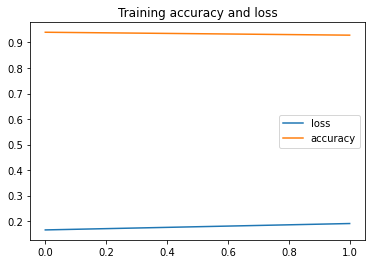

In [ ]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["accuracy"],label="accuracy")
plt.title("Training accuracy and loss")
plt.legend()

## Evaluating the model

In [ ]:
loss, accuracy = .evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)